In [67]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import joblib  # 모델 저장을 위한 joblib
import json  # JSON 파일 저장을 위한 json 모듈
import onnxmltools
from onnxconverter_common import FloatTensorType

In [68]:
# CSV 파일이 저장된 폴더 경로
folder_path = 'C:/Users/insang/chaewon/data'

In [69]:
# 폴더 내 모든 CSV 파일 불러오기
all_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

In [70]:
# 모든 CSV 파일을 하나의 DataFrame으로 합치기
data_frames = [pd.read_csv(f) for f in all_files]
data = pd.concat(data_frames, ignore_index=True)

In [71]:
# 데이터 개수 확인
print(f"총 데이터 개수: {len(data)}")

총 데이터 개수: 603856


In [72]:
# 주차장명, timestamp, 요일 등을 포함한 데이터 확인
print(data.head())

             PKLT_NM  TPKCT  NOW_PRK_VHCL_CNT            timestamp   weekday
0  구로디지털단지역 공영주차장(시)     91                55  2024-09-12 21:50:02  Thursday
1  구로디지털단지역 공영주차장(시)     91                53  2024-09-12 22:00:08  Thursday
2  구로디지털단지역 공영주차장(시)     91                51  2024-09-12 22:10:02  Thursday
3  구로디지털단지역 공영주차장(시)     91                47  2024-09-12 22:20:02  Thursday
4  구로디지털단지역 공영주차장(시)     91                48  2024-09-12 22:30:02  Thursday


In [73]:
# 1. 혼잡도 레이블 생성 (여유: 0, 보통: 1, 혼잡: 2)
def create_congestion_label(row):
    utilization = row['NOW_PRK_VHCL_CNT'] / row['TPKCT']
    if utilization < 0.5:
        return 0  # 여유
    elif utilization < 0.8:
        return 1  # 보통
    else:
        return 2  # 혼잡

In [74]:
data['congestion'] = data.apply(create_congestion_label, axis=1)

In [75]:
# 2. One-Hot Encoding for PKLT_NM and weekday
onehot = ColumnTransformer(
    transformers=[
        ('parking_name', OneHotEncoder(), ['PKLT_NM']),
        ('weekday', OneHotEncoder(), ['weekday'])
    ],
    remainder='passthrough'  # 나머지 컬럼은 그대로 유지
)

In [76]:
# 시간 정보 추가 (시간과 분까지 사용)
data['hour'] = pd.to_datetime(data['timestamp']).dt.hour
data['minute'] = pd.to_datetime(data['timestamp']).dt.minute

In [77]:
# 필요한 컬럼만 선택
features = ['PKLT_NM', 'weekday', 'hour', 'minute']
target = 'congestion'

In [78]:
# 3. One-Hot Encoding과 정규화를 동시에 적용하고 sparse matrix를 dense로 변환
data_encoded = onehot.fit_transform(data[features]).toarray()  # One-hot encoding
scaler = MinMaxScaler()
data_encoded_scaled = scaler.fit_transform(data_encoded)  # 정규화

In [79]:
# 4. XGBClassifier 모델 사용
X = data_encoded_scaled
y = data[target].values

In [80]:
# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

In [81]:
# XGBoost 모델 정의
model = XGBClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [82]:
# 모델 저장
model_filename = 'parking_congestion_model_xgb.pkl'
joblib.dump(model, model_filename)
print(f"모델이 {model_filename} 파일로 저장되었습니다.")

모델이 parking_congestion_model_xgb.pkl 파일로 저장되었습니다.


In [83]:
# 인코더와 스케일러 정보 JSON으로 저장
# OneHotEncoder 정보 저장
encoder_info = {
    'categories': [list(cat) for cat in onehot.named_transformers_['parking_name'].categories_] +
                  [list(cat) for cat in onehot.named_transformers_['weekday'].categories_]
}

In [84]:
# MinMaxScaler 정보 저장
scaler_info = {
    'min': scaler.data_min_.tolist(),
    'max': scaler.data_max_.tolist()
}

In [85]:
# JSON 파일로 저장
with open('onehot_encoder_info.json', 'w') as f:
    json.dump(encoder_info, f)

with open('scaler_info.json', 'w') as f:
    json.dump(scaler_info, f)

print("OneHotEncoder와 MinMaxScaler 정보가 JSON 파일로 저장되었습니다.")

OneHotEncoder와 MinMaxScaler 정보가 JSON 파일로 저장되었습니다.


In [86]:
# 모델 불러오기
loaded_model = joblib.load(model_filename)
print("모델이 성공적으로 불러와졌습니다.")

모델이 성공적으로 불러와졌습니다.


In [87]:
# 5. 예측 (불러온 모델로 예측)
predictions = loaded_model.predict(X_test)

In [88]:
# 예측 결과 확인
accuracy = accuracy_score(y_test, predictions)
print(f'정확도: {accuracy:.4f}')

정확도: 0.8250


In [89]:
# 상세한 성능 평가
print(classification_report(y_test, predictions, target_names=['여유', '보통', '혼잡']))

              precision    recall  f1-score   support

          여유       0.84      0.93      0.88     55925
          보통       0.81      0.77      0.79     43908
          혼잡       0.81      0.67      0.73     20939

    accuracy                           0.83    120772
   macro avg       0.82      0.79      0.80    120772
weighted avg       0.82      0.83      0.82    120772



In [90]:
# 6. 특정 시간대 예측 함수
def get_similar_time_data(data, parking_name, weekday, hour):
    # 같은 주차장, 같은 요일, 유사한 시간대(예: ±1시간)에 해당하는 데이터를 필터링
    similar_data = data[
        (data['PKLT_NM'] == parking_name) &
        (data['weekday'] == weekday) &
        (abs(data['hour'] - hour) <= 1)  # 시간대 ±1시간 필터링
    ]
    return similar_data

In [91]:
# 예측 함수 수정
def predict_congestion_with_similar_data(parking_name, weekday, hour, minute):
    try:
        # 주차장명, 요일, 시간에 해당하는 유사 데이터 추출
        similar_data = get_similar_time_data(data, parking_name, weekday, hour)

        if similar_data.empty:
            raise ValueError("해당 시간대에 유사한 데이터가 없습니다.")

        # 입력 데이터를 One-Hot Encoding 및 정규화
        input_encoded = onehot.transform(similar_data[features]).toarray()
        input_scaled = scaler.transform(input_encoded)

        # 예측 수행 (불러온 모델 사용)
        predicted_class = loaded_model.predict(input_scaled)

        return predicted_class[0]
    except Exception as e:
        print(f"예측 과정에서 오류 발생: {e}")
        return None

In [92]:
# # 예시 입력으로 혼잡도 예측
# parking_name = "구로디지털단지역 공영주차장(시)"
# weekday = 'Monday'  # 수요일
# hour = 1
# minute = 37

In [93]:
# 예시 입력으로 혼잡도 예측
parking_name = "세종로 공영주차장(시)"
weekday = 'Monday'  # 수요일
hour = 5
minute = 34

In [94]:
predicted_level = predict_congestion_with_similar_data(parking_name, weekday, hour, minute)
congestion_mapping = {0: '여유', 1: '보통', 2: '혼잡'}
if predicted_level is not None:
    print(f"예측된 혼잡도: {congestion_mapping[predicted_level]}")

예측된 혼잡도: 여유


In [95]:
# ONNX 변환 부분
# 기존 학습된 모델 (loaded_model)로 변환
booster = loaded_model.get_booster()

In [96]:
# 모델을 ONNX로 변환
initial_type = [('float_input', FloatTensorType([None, X_train.shape[1]]))]
onnx_model = onnxmltools.convert_xgboost(booster, initial_types=initial_type)

In [97]:
# ONNX 모델 저장
onnx_model_path = "xgboost_model_with_onehot.onnx"
with open(onnx_model_path, "wb") as f:
    f.write(onnx_model.SerializeToString())

print(f"ONNX 모델이 {onnx_model_path} 파일로 저장되었습니다.")


ONNX 모델이 xgboost_model_with_onehot.onnx 파일로 저장되었습니다.


In [98]:
import onnxruntime as rt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# ONNX 모델 로드
onnx_model_path = "xgboost_model_with_onehot.onnx"
sess = rt.InferenceSession(onnx_model_path)

# JSON으로 저장된 OneHotEncoder 및 MinMaxScaler 정보 로드
with open('onehot_encoder_info.json', 'r') as f:
    encoder_info = json.load(f)

with open('scaler_info.json', 'r') as f:
    scaler_info = json.load(f)

# 정규화 함수 (MinMaxScaler와 동일하게 적용)
def apply_scaler(input_data, scaler_info):
    min_val = np.array(scaler_info['min'])
    max_val = np.array(scaler_info['max'])
    return (input_data - min_val) / (max_val - min_val)

# 입력 데이터 전처리 함수
def preprocess_input(parking_name, weekday, hour, minute):
    # 주차장명과 요일을 원핫인코딩
    parking_names = encoder_info['categories'][0]
    weekdays = encoder_info['categories'][1]
    
    parking_onehot = [1 if parking_name == name else 0 for name in parking_names]
    weekday_onehot = [1 if weekday == day else 0 for day in weekdays]
    
    # 시간 및 분 추가
    input_data = parking_onehot + weekday_onehot + [hour, minute]
    
    # 입력 데이터를 정규화
    input_scaled = apply_scaler(np.array(input_data), scaler_info)
    
    return input_scaled.reshape(1, -1)  # 모델 입력에 맞는 형태로 변환

# ONNX 모델을 사용하여 예측 수행
def predict_congestion_onnx(parking_name, weekday, hour, minute):
    # 입력 데이터를 전처리
    input_data = preprocess_input(parking_name, weekday, hour, minute)
    
    # ONNX 모델에 입력 데이터를 넣어 예측 수행
    input_name = sess.get_inputs()[0].name
    prediction = sess.run(None, {input_name: input_data.astype(np.float32)})
    
    return prediction[0][0]  # 예측 결과 반환 (혼잡도 클래스)

# 테스트 데이터 전체에 대해 예측을 수행하고 정확도를 평가하는 함수
def evaluate_model_onnx(test_data, original_data):
    predictions = []
    actuals = []
    
    for index, row in test_data.iterrows():
        parking_name = row['PKLT_NM']
        weekday = row['weekday']
        hour = row['hour']
        minute = row['minute']
        actual = row['congestion']  # 실제 레이블 (혼잡도)
        
        predicted = predict_congestion_onnx(parking_name, weekday, hour, minute)
        predictions.append(predicted)
        actuals.append(actual)
    
    # 정확도 계산
    accuracy = accuracy_score(actuals, predictions)
    print(f'정확도: {accuracy:.4f}')
    
    # 상세한 성능 평가
    print(classification_report(actuals, predictions, target_names=['여유', '보통', '혼잡']))

# Train/Test Split, 인덱스 정보 추가
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, data.index, test_size=0.2, shuffle=True)

# 테스트 데이터에 대한 평가 수행
evaluate_model_onnx(data.iloc[test_indices], data)

정확도: 0.8263
              precision    recall  f1-score   support

          여유       0.84      0.93      0.88     55802
          보통       0.81      0.77      0.79     44071
          혼잡       0.81      0.67      0.73     20899

    accuracy                           0.83    120772
   macro avg       0.82      0.79      0.80    120772
weighted avg       0.82      0.83      0.82    120772



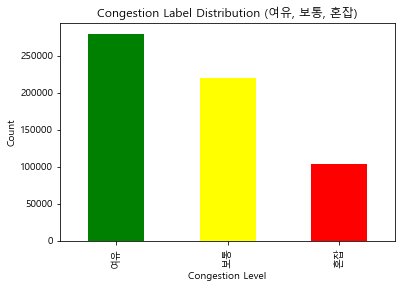

In [104]:
import matplotlib.pyplot as plt

# 혼잡도 레이블의 분포 시각화 (0 -> '여유', 1 -> '보통', 2 -> '혼잡')
congestion_labels = {0: '여유', 1: '보통', 2: '혼잡'}
congestion_counts = data['congestion'].value_counts().sort_index()  # sort_index()로 0, 1, 2 순서로 정렬

# 막대그래프 그리기
congestion_counts.plot(kind='bar', color=['green', 'yellow', 'red'])

# x축 레이블을 '여유', '보통', '혼잡'으로 변경
plt.xticks(ticks=range(len(congestion_counts)), labels=[congestion_labels[idx] for idx in congestion_counts.index])

plt.title('Congestion Label Distribution (여유, 보통, 혼잡)')
plt.xlabel('Congestion Level')
plt.ylabel('Count')
plt.show()

In [100]:
import onnxruntime as rt
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# ONNX 모델 로드
onnx_model_path = "xgboost_model_with_onehot.onnx"
sess = rt.InferenceSession(onnx_model_path)

# JSON으로 저장된 OneHotEncoder 및 MinMaxScaler 정보 로드
with open('onehot_encoder_info.json', 'r') as f:
    encoder_info = json.load(f)

with open('scaler_info.json', 'r') as f:
    scaler_info = json.load(f)

# 정규화 함수 (MinMaxScaler와 동일하게 적용)
def apply_scaler(input_data, scaler_info):
    min_val = np.array(scaler_info['min'])
    max_val = np.array(scaler_info['max'])
    return (input_data - min_val) / (max_val - min_val)

# 입력 데이터 전처리 함수
def preprocess_input(parking_name, weekday, hour, minute):
    # 주차장명과 요일을 원핫인코딩
    parking_names = encoder_info['categories'][0]
    weekdays = encoder_info['categories'][1]
    
    parking_onehot = [1 if parking_name == name else 0 for name in parking_names]
    weekday_onehot = [1 if weekday == day else 0 for day in weekdays]
    
    # 시간 및 분 추가
    input_data = parking_onehot + weekday_onehot + [hour, minute]
    
    # 입력 데이터를 정규화
    input_scaled = apply_scaler(np.array(input_data), scaler_info)
    
    return input_scaled.reshape(1, -1)  # 모델 입력에 맞는 형태로 변환

# ONNX 모델을 사용하여 예측 수행
def predict_congestion_onnx(parking_name, weekday, hour, minute):
    # 입력 데이터를 전처리
    input_data = preprocess_input(parking_name, weekday, hour, minute)
    
    # ONNX 모델에 입력 데이터를 넣어 예측 수행
    input_name = sess.get_inputs()[0].name
    prediction = sess.run(None, {input_name: input_data.astype(np.float32)})
    
    return prediction[0][0]  # 예측 결과 반환 (혼잡도 클래스)

# 테스트 데이터 전체에 대해 예측을 수행하고 정확도를 평가하는 함수
def evaluate_model_onnx(test_data, original_data):
    predictions = []
    actuals = []
    
    for index, row in test_data.iterrows():
        parking_name = row['PKLT_NM']
        weekday = row['weekday']
        hour = row['hour']
        minute = row['minute']
        actual = row['congestion']  # 실제 레이블 (혼잡도)
        
        predicted = predict_congestion_onnx(parking_name, weekday, hour, minute)
        predictions.append(predicted)
        actuals.append(actual)
    
    # 정확도 계산
    accuracy = accuracy_score(actuals, predictions)
    print(f'정확도: {accuracy:.4f}')
    
    # 상세한 성능 평가
    print(classification_report(actuals, predictions, target_names=['여유', '보통', '혼잡']))

# Train/Test Split, 인덱스 정보 추가
X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(X, y, data.index, test_size=0.2, shuffle=True)

# 테스트 데이터에 대한 평가 수행
evaluate_model_onnx(data.iloc[test_indices], data)

정확도: 0.8270
              precision    recall  f1-score   support

          여유       0.85      0.93      0.88     55910
          보통       0.81      0.77      0.79     44091
          혼잡       0.81      0.67      0.73     20771

    accuracy                           0.83    120772
   macro avg       0.82      0.79      0.80    120772
weighted avg       0.83      0.83      0.82    120772



c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50668 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 50976 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 48372 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 53685 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 54844 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\ProgramData\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 51105 missing from c

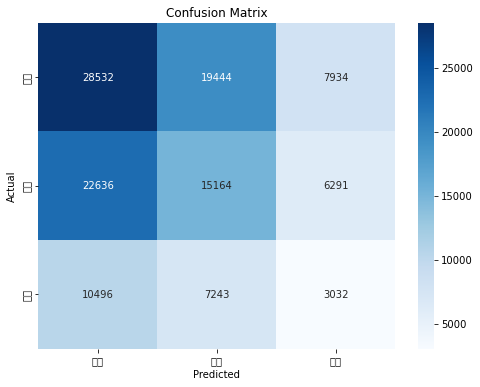

In [101]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 혼동 행렬 계산
cm = confusion_matrix(y_test, predictions)

# 혼동 행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['여유', '보통', '혼잡'], yticklabels=['여유', '보통', '혼잡'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

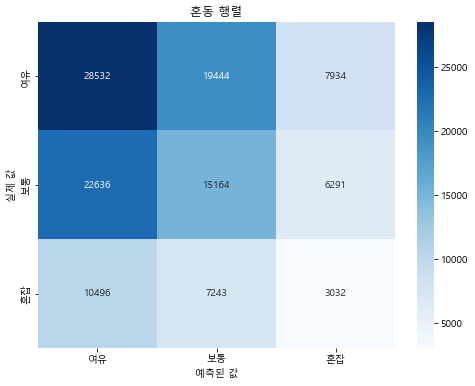

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib import font_manager, rc

# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows의 경우 맑은 고딕 폰트 경로
font_name = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font_name)

# 혼동 행렬 시각화 예시
cm = confusion_matrix(y_test, predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['여유', '보통', '혼잡'], yticklabels=['여유', '보통', '혼잡'])
plt.title('혼동 행렬')
plt.xlabel('예측된 값')
plt.ylabel('실제 값')
plt.show()